In [1]:
import numpy as np
import pandas as pd
import psycopg2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'week1',
    'user': 'postgres',
    'password': 'habte',
    'host': 'localhost',
    'port': '5432'
}

# Create a SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')

# SQL query to retrieve data
sql_query = "SELECT * FROM xdr_data;"

# Read data from PostgreSQL into a DataFrame
mydata = pd.read_sql_query(sql_query, engine)

In [4]:
mydata.head(5)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
# Process the data
mydata['Start'] = pd.to_datetime(mydata['Start'])
mydata['End'] = pd.to_datetime(mydata['End'])
mydata['session_duration'] = (mydata['End'] - mydata['Start']).dt.total_seconds()

In [7]:
# Calculate engagement metrics
session_frequency = mydata.groupby('MSISDN/Number')['Bearer Id'].count()
average_session_duration = mydata.groupby('MSISDN/Number')['session_duration'].mean()
total_data_usage = mydata.groupby('MSISDN/Number')['Total UL (Bytes)'].sum() + mydata.groupby('MSISDN/Number')['Total DL (Bytes)'].sum()

In [8]:
# Combine metrics into an engagement score
engagement_score = 0.4 * session_frequency + 0.6 * average_session_duration + 0.0 * total_data_usage

In [34]:
# Create a new DataFrame with engagement metrics
engagement_mydata = pd.DataFrame({
    'MSISDN/Number': engagement_score.index,
    'session_frequency': session_frequency.values,
    'average_session_duration': average_session_duration.values,
    'total_data_usage': total_data_usage.values,
    'engagement_score': engagement_score.values
})

In [35]:
# Display the engagement metrics DataFrame
print(engagement_mydata)

        MSISDN/Number  session_frequency  average_session_duration  \
0        3.360100e+10                  1                  116760.0   
1        3.360100e+10                  1                  181260.0   
2        3.360100e+10                  1                  135000.0   
3        3.360101e+10                  1                   49920.0   
4        3.360101e+10                  2                   18600.0   
...               ...                ...                       ...   
106851   3.379000e+10                  1                    8760.0   
106852   3.379000e+10                  1                  141000.0   
106853   3.197021e+12                  1                  877380.0   
106854   3.370000e+14                  1                  253020.0   
106855   8.823971e+14                  1                  869820.0   

        total_data_usage  engagement_score  
0           8.786906e+08       263653876.5  
1           1.568596e+08        47130397.2  
2           5.959665e+08

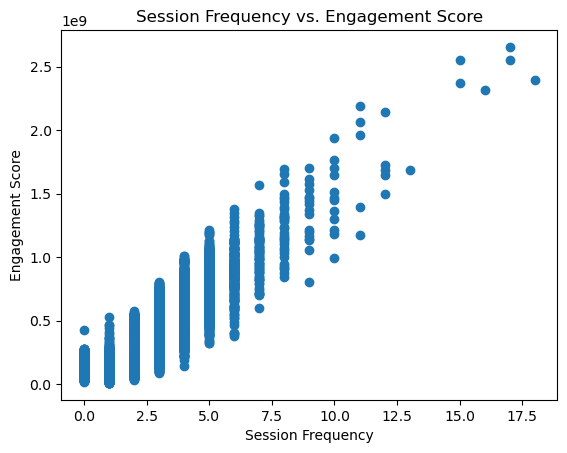

In [36]:
# Visualize the data (you can customize the plots based on your needs)
plt.scatter(engagement_mydata['session_frequency'], engagement_mydata['engagement_score'])
plt.xlabel('Session Frequency')
plt.ylabel('Engagement Score')
plt.title('Session Frequency vs. Engagement Score')
plt.show()

In [37]:
# Report the top 10 customers for each engagement metric
top_10_session_frequency = engagement_df.nlargest(10, 'session_frequency')
top_10_average_session_duration = engagement_df.nlargest(10, 'average_session_duration')
top_10_total_data_usage = engagement_df.nlargest(10, 'total_data_usage')
top_10_engagement_score = engagement_df.nlargest(10, 'engagement_score')

In [38]:
# Display the results
print("Top 10 Customers by Session Frequency:")
print(top_10_session_frequency)

print("\nTop 10 Customers by Average Session Duration:")
print(top_10_average_session_duration)

print("\nTop 10 Customers by Total Data Usage:")
print(top_10_total_data_usage)

print("\nTop 10 Customers by Engagement Score:")
print(top_10_engagement_score)

Top 10 Customers by Session Frequency:
       MSISDN/Number  session_frequency  average_session_duration  \
13526   3.362632e+10                 18              4.884600e+05   
6437    3.361489e+10                 17              5.863059e+05   
13180   3.362578e+10                 17              1.091396e+06   
37052   3.365973e+10                 16              2.522025e+05   
76363   3.367588e+10                 15              3.243760e+05   
92923   3.376054e+10                 15              6.186440e+05   
65118   3.366716e+10                 13              6.726600e+05   
666     3.360313e+10                 12              5.240000e+05   
1279    3.360452e+10                 12              4.340050e+05   
13994   3.362708e+10                 12              3.919550e+05   

       total_data_usage  engagement_score  
13526      7.971167e+09      2.391546e+09  
6437       8.846226e+09      2.654102e+09  
13180      8.499621e+09      2.550323e+09  
37052      7.705863e+09  

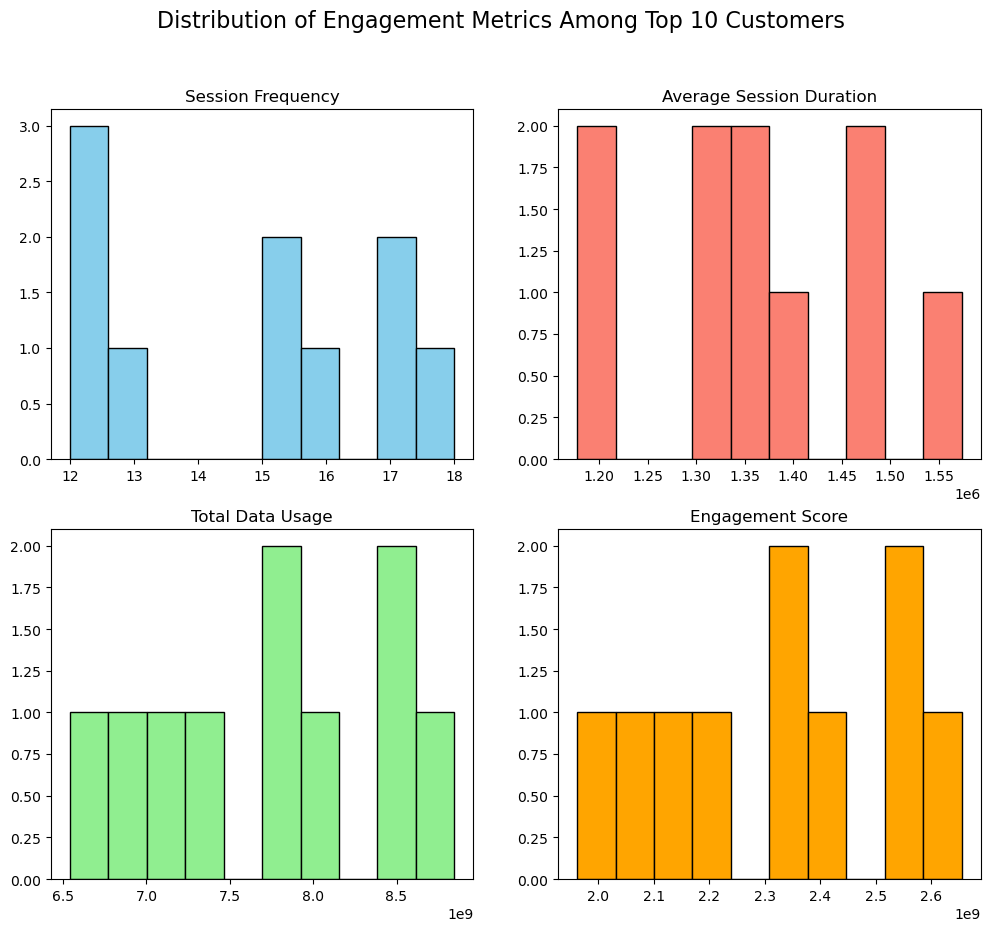

In [50]:
import matplotlib.pyplot as plt

# Plot histograms for each engagement metric
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of Engagement Metrics Among Top 10 Customers', fontsize=16)

# Session Frequency
axs[0, 0].hist(top_10_session_frequency['session_frequency'], bins=10, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Session Frequency')

# Average Session Duration
axs[0, 1].hist(top_10_average_session_duration['average_session_duration'], bins=10, color='salmon', edgecolor='black')
axs[0, 1].set_title('Average Session Duration')

# Total Data Usage
axs[1, 0].hist(top_10_total_data_usage['total_data_usage'], bins=10, color='lightgreen', edgecolor='black')
axs[1, 0].set_title('Total Data Usage')

# Engagement Score
axs[1, 1].hist(top_10_engagement_score['engagement_score'], bins=10, color='orange', edgecolor='black')
axs[1, 1].set_title('Engagement Score')

plt.show()


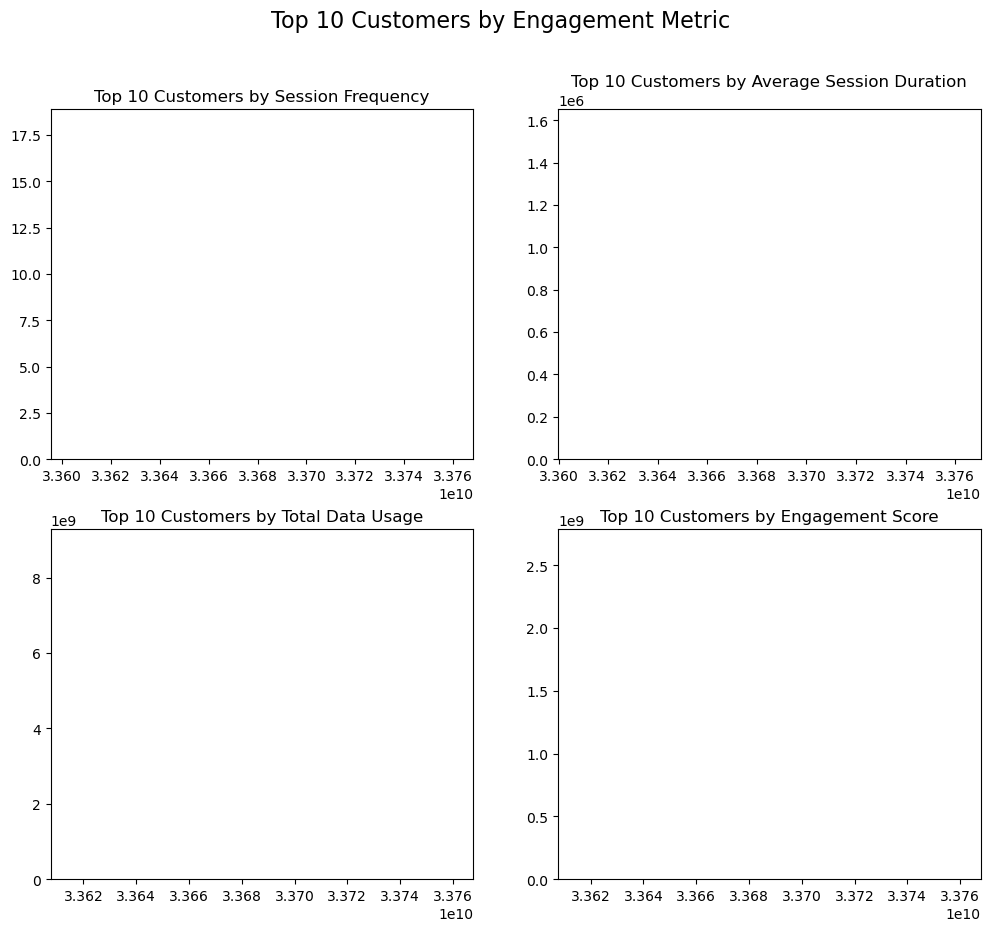

In [51]:
# Plot bar plots for the top 10 customers for each engagement metric
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Top 10 Customers by Engagement Metric', fontsize=16)

# Session Frequency
axs[0, 0].bar(top_10_session_frequency['MSISDN/Number'], top_10_session_frequency['session_frequency'], color='skyblue')
axs[0, 0].set_title('Top 10 Customers by Session Frequency')

# Average Session Duration
axs[0, 1].bar(top_10_average_session_duration['MSISDN/Number'], top_10_average_session_duration['average_session_duration'], color='salmon')
axs[0, 1].set_title('Top 10 Customers by Average Session Duration')

# Total Data Usage
axs[1, 0].bar(top_10_total_data_usage['MSISDN/Number'], top_10_total_data_usage['total_data_usage'], color='lightgreen')
axs[1, 0].set_title('Top 10 Customers by Total Data Usage')

# Engagement Score
axs[1, 1].bar(top_10_engagement_score['MSISDN/Number'], top_10_engagement_score['engagement_score'], color='orange')
axs[1, 1].set_title('Top 10 Customers by Engagement Score')

plt.show()


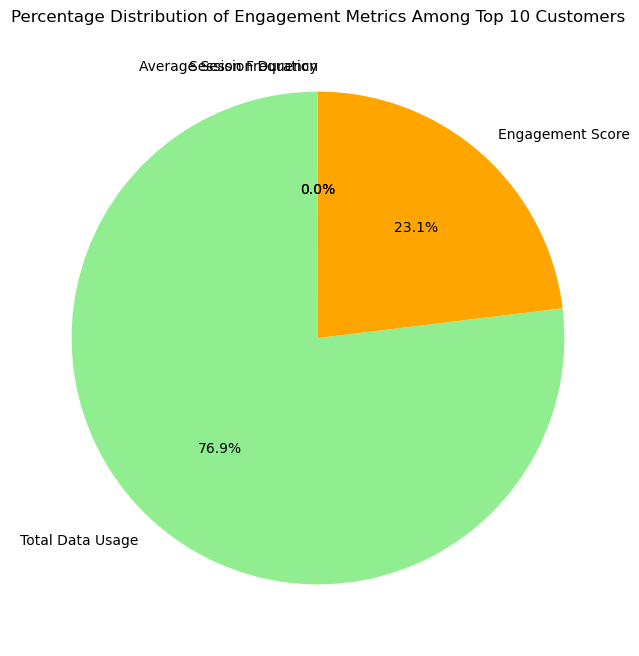

In [52]:
# Calculate total values for each engagement metric
total_session_frequency = top_10_session_frequency['session_frequency'].sum()
total_average_session_duration = top_10_average_session_duration['average_session_duration'].sum()
total_total_data_usage = top_10_total_data_usage['total_data_usage'].sum()
total_engagement_score = top_10_engagement_score['engagement_score'].sum()

# Data for the pie chart
data = [total_session_frequency, total_average_session_duration, total_total_data_usage, total_engagement_score]

# Define labels for each engagement metric
labels = ['Session Frequency', 'Average Session Duration', 'Total Data Usage', 'Engagement Score']

# Define colors for the pie chart
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Percentage Distribution of Engagement Metrics Among Top 10 Customers')
plt.show()
